In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# XGBoost
import xgboost as xgb

np.random.seed(42)
sns.set_style("whitegrid")

print("All imports successful! ✅")
print(f"XGBoost version: {xgb.__version__}")

All imports successful! ✅
XGBoost version: 3.1.1


## 1. Load Data and Separate Labeled/Unlabeled


In [2]:
# Load data
df = pd.read_csv("Analytica.csv")

print(f"Total samples: {len(df)}")
print(f"Labeled samples (non-NaN target): {df['target'].notna().sum()}")
print(f"Unlabeled samples (NaN target): {df['target'].isna().sum()}")

# Separate labeled and unlabeled data
df_labeled = df[df["target"].notna()].copy()
df_unlabeled = df[df["target"].isna()].copy()

print(f"\nLabeled data shape: {df_labeled.shape}")
print(f"Unlabeled data shape: {df_unlabeled.shape}")

Total samples: 34163
Labeled samples (non-NaN target): 5096
Unlabeled samples (NaN target): 29067

Labeled data shape: (5096, 112)
Unlabeled data shape: (29067, 112)


In [3]:
# Check class distribution in labeled data
print("Class distribution in labeled data:")
print(df_labeled["target"].value_counts())
print(f"\nClass balance: {df_labeled['target'].mean():.2%} are class 1")

Class distribution in labeled data:
target
0.0    2683
1.0    2413
Name: count, dtype: int64

Class balance: 47.35% are class 1


## 2. Preprocessing: StandardScaler + PCA


In [4]:
# Extract features (exclude ID and target)
feature_cols = [col for col in df.columns if col not in ["ID", "target"]]
print(f"Number of features: {len(feature_cols)}")

X_labeled = df_labeled[feature_cols].values
y_labeled = df_labeled["target"].values.astype(int)
X_unlabeled = df_unlabeled[feature_cols].values
unlabeled_ids = df_unlabeled["ID"].values

print(f"X_labeled shape: {X_labeled.shape}")
print(f"X_unlabeled shape: {X_unlabeled.shape}")

Number of features: 110
X_labeled shape: (5096, 110)
X_unlabeled shape: (29067, 110)


In [5]:
# StandardScaler - fit on ALL data for clustering
X_all = np.vstack([X_labeled, X_unlabeled])
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

X_labeled_scaled = X_all_scaled[: len(X_labeled)]
X_unlabeled_scaled = X_all_scaled[len(X_labeled) :]

print(f"Scaled data - Mean: {X_all_scaled.mean():.4f}, Std: {X_all_scaled.std():.4f}")

Scaled data - Mean: 0.0000, Std: 1.0000


In [6]:
# Find optimal PCA components
pca_full = PCA()
pca_full.fit(X_all_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find n_components for different thresholds
thresholds = [0.80, 0.85, 0.90, 0.95]
for thresh in thresholds:
    n_comp = np.argmax(cumulative_variance >= thresh) + 1
    print(f"{thresh*100:.0f}% variance explained with {n_comp} components")

80% variance explained with 59 components
85% variance explained with 67 components
90% variance explained with 75 components
95% variance explained with 86 components


In [7]:
# Apply PCA
n_components = 86  # ~87% variance
pca = PCA(n_components=n_components)
X_all_pca = pca.fit_transform(X_all_scaled)

X_labeled_pca = X_all_pca[: len(X_labeled)]
X_unlabeled_pca = X_all_pca[len(X_labeled) :]

print(f"PCA with {n_components} components")
print(f"Explained variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")
print(f"X_labeled_pca shape: {X_labeled_pca.shape}")
print(f"X_unlabeled_pca shape: {X_unlabeled_pca.shape}")

PCA with 86 components
Explained variance: 95.29%
X_labeled_pca shape: (5096, 86)
X_unlabeled_pca shape: (29067, 86)


## 3. Unsupervised Learning: KMeans Clustering

We apply KMeans clustering on ALL data (labeled + unlabeled) to leverage the unsupervised structure of the entire dataset. The cluster labels are then used as an additional feature for XGBoost.


In [8]:
# Find optimal number of clusters using silhouette score
print(f"Total samples for clustering: {X_all_pca.shape[0]}")

cluster_range = range(84, 85)
silhouette_scores = []
inertias = []

for k in cluster_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_all_pca)
    score = silhouette_score(X_all_pca, labels_temp)
    silhouette_scores.append(score)
    inertias.append(kmeans_temp.inertia_)
    print(f"k={k}: Silhouette Score = {score:.4f}")

best_k = list(cluster_range)[np.argmax(silhouette_scores)]
print(f"\nBest number of clusters: {best_k}")

Total samples for clustering: 34163
k=84: Silhouette Score = -0.0158

Best number of clusters: 84
k=84: Silhouette Score = -0.0158

Best number of clusters: 84


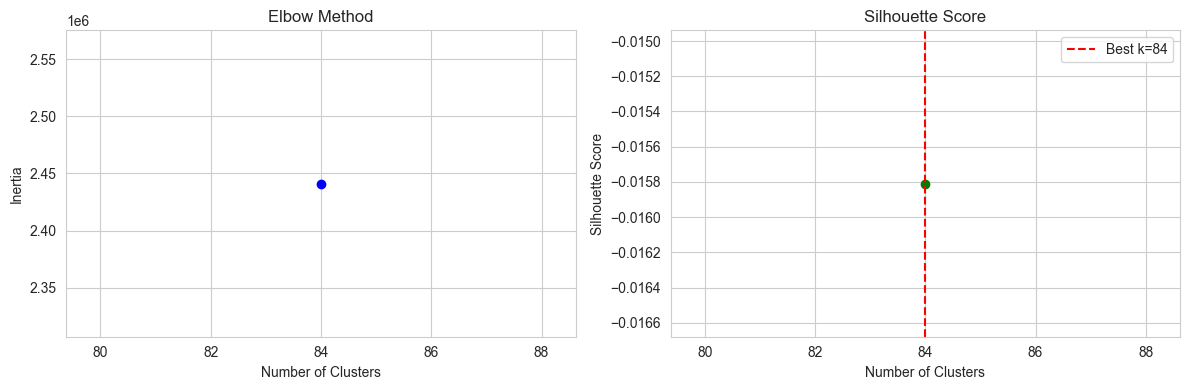

In [9]:
# Plot silhouette scores and elbow
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(cluster_range, inertias, "b-o")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Inertia")
axes[0].set_title("Elbow Method")

axes[1].plot(cluster_range, silhouette_scores, "g-o")
axes[1].axvline(x=best_k, color="r", linestyle="--", label=f"Best k={best_k}")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score")
axes[1].legend()

plt.tight_layout()
plt.show()

In [10]:
# Fit KMeans with optimal k
n_clusters = best_k
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
all_cluster_labels = kmeans.fit_predict(X_all_pca)

# Split cluster labels back to labeled and unlabeled
cluster_labels_labeled = all_cluster_labels[: len(X_labeled_pca)]
cluster_labels_unlabeled = all_cluster_labels[len(X_labeled_pca) :]

print(f"Cluster distribution:")
for i in range(n_clusters):
    count = np.sum(all_cluster_labels == i)
    print(f"  Cluster {i}: {count} samples ({count/len(all_cluster_labels)*100:.1f}%)")

print(
    f"\nFinal Silhouette Score: {silhouette_score(X_all_pca, all_cluster_labels):.4f}"
)

Cluster distribution:
  Cluster 0: 238 samples (0.7%)
  Cluster 1: 681 samples (2.0%)
  Cluster 2: 171 samples (0.5%)
  Cluster 3: 642 samples (1.9%)
  Cluster 4: 333 samples (1.0%)
  Cluster 5: 542 samples (1.6%)
  Cluster 6: 432 samples (1.3%)
  Cluster 7: 782 samples (2.3%)
  Cluster 8: 170 samples (0.5%)
  Cluster 9: 334 samples (1.0%)
  Cluster 10: 197 samples (0.6%)
  Cluster 11: 167 samples (0.5%)
  Cluster 12: 168 samples (0.5%)
  Cluster 13: 686 samples (2.0%)
  Cluster 14: 808 samples (2.4%)
  Cluster 15: 52 samples (0.2%)
  Cluster 16: 606 samples (1.8%)
  Cluster 17: 520 samples (1.5%)
  Cluster 18: 397 samples (1.2%)
  Cluster 19: 137 samples (0.4%)
  Cluster 20: 501 samples (1.5%)
  Cluster 21: 629 samples (1.8%)
  Cluster 22: 646 samples (1.9%)
  Cluster 23: 607 samples (1.8%)
  Cluster 24: 294 samples (0.9%)
  Cluster 25: 386 samples (1.1%)
  Cluster 26: 252 samples (0.7%)
  Cluster 27: 533 samples (1.6%)
  Cluster 28: 154 samples (0.5%)
  Cluster 29: 375 samples (1.1%)

In [11]:
# One-hot encode cluster labels
encoder = OneHotEncoder(sparse_output=False)
cluster_onehot_labeled = encoder.fit_transform(cluster_labels_labeled.reshape(-1, 1))
cluster_onehot_unlabeled = encoder.transform(cluster_labels_unlabeled.reshape(-1, 1))

# Combine PCA features with cluster one-hot encoding
X_labeled_final = np.hstack([X_labeled_pca, cluster_onehot_labeled])
X_unlabeled_final = np.hstack([X_unlabeled_pca, cluster_onehot_unlabeled])

print(f"Final labeled features shape: {X_labeled_final.shape}")
print(f"Final unlabeled features shape: {X_unlabeled_final.shape}")
print(f"Features: {n_components} PCA components + {n_clusters} cluster indicators")

Final labeled features shape: (5096, 170)
Final unlabeled features shape: (29067, 170)
Features: 86 PCA components + 84 cluster indicators


## 4. XGBoost with Stratified K-Fold Cross-Validation


In [12]:
# Split for initial evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled_final, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

Training set: 4076 samples
Test set: 1020 samples
Features: 170


In [13]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 1.11


In [14]:
# Basic XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

# Fit with early stopping
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Evaluate
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 76.57%
Test ROC-AUC: 0.8465

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       537
           1       0.74      0.77      0.76       483

    accuracy                           0.77      1020
   macro avg       0.77      0.77      0.77      1020
weighted avg       0.77      0.77      0.77      1020



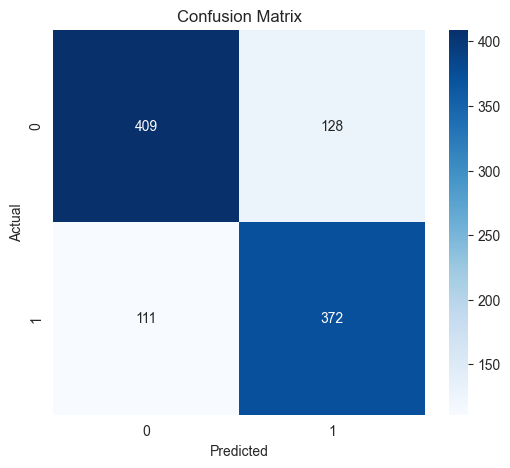

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 5. Hyperparameter Tuning with GridSearchCV


In [16]:
# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.15],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

# Smaller grid for faster search
param_grid_small = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
}

print("Starting GridSearchCV...")

xgb_cv = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

grid_search = GridSearchCV(
    xgb_cv,
    param_grid_small,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_*100:.2f}%")

Starting GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best CV accuracy: 77.94%

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best CV accuracy: 77.94%


In [17]:
# Evaluate best model on test set
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print(f"Best Model Test Accuracy: {accuracy_score(y_test, y_pred_best)*100:.2f}%")
print(f"Best Model Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Best Model Test Accuracy: 75.49%
Best Model Test ROC-AUC: 0.8494

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       537
           1       0.73      0.76      0.75       483

    accuracy                           0.75      1020
   macro avg       0.75      0.76      0.75      1020
weighted avg       0.76      0.75      0.76      1020



## 6. Feature Importance


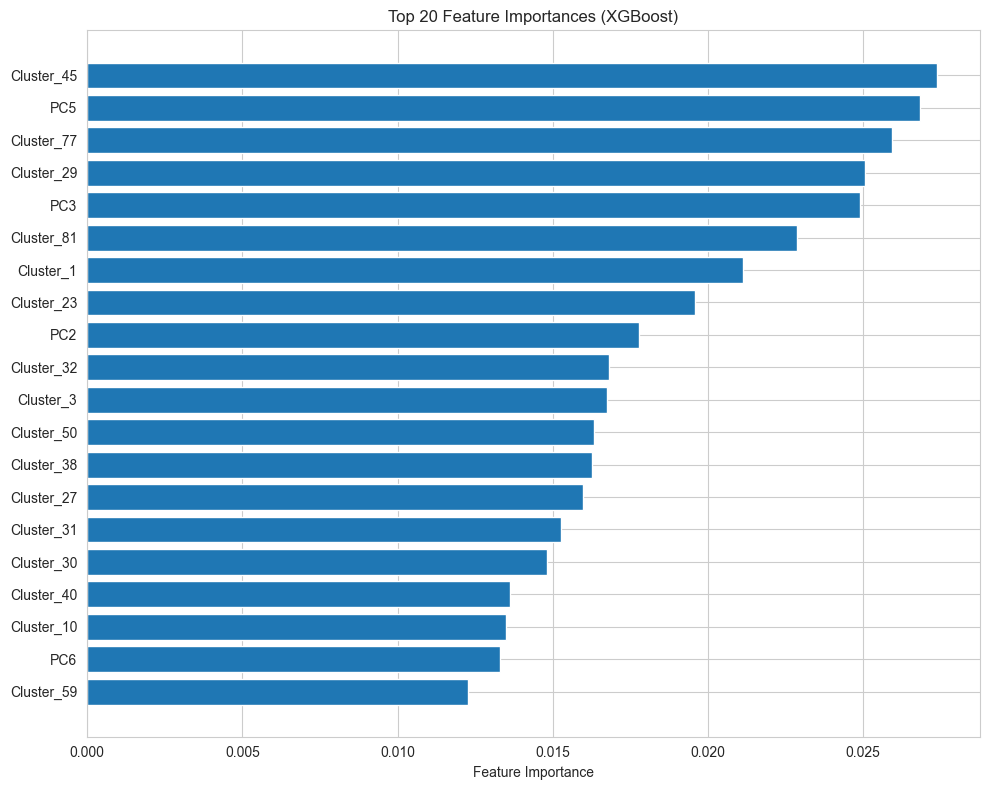

In [18]:
# Plot feature importance
feature_names = [f"PC{i+1}" for i in range(n_components)] + [
    f"Cluster_{i}" for i in range(n_clusters)
]
importance = best_model.feature_importances_

# Get top 20 features
indices = np.argsort(importance)[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importance[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

## 7. Cross-Validation Ensemble Predictions


In [19]:
# Stratified K-Fold with ensemble predictions
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_accuracies = []
all_predictions = np.zeros((len(X_unlabeled_final), 2))  # Store probabilities

print(f"Starting {n_folds}-Fold Cross-Validation Ensemble...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_labeled_final, y_labeled)):
    print(f"Fold {fold+1}/{n_folds}")

    X_tr, X_val = X_labeled_final[train_idx], X_labeled_final[val_idx]
    y_tr, y_val = y_labeled[train_idx], y_labeled[val_idx]

    # Train XGBoost
    model = xgb.XGBClassifier(
        **grid_search.best_params_,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    )
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

    # Validate
    val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    fold_accuracies.append(val_acc)
    print(f"  Validation Accuracy: {val_acc*100:.2f}%")

    # Predict on unlabeled data
    probs = model.predict_proba(X_unlabeled_final)
    all_predictions += probs

print(f"\n{'='*50}")
print(
    f"Mean CV Accuracy: {np.mean(fold_accuracies)*100:.2f}% (+/- {np.std(fold_accuracies)*100:.2f}%)"
)

Starting 5-Fold Cross-Validation Ensemble...

Fold 1/5
  Validation Accuracy: 76.18%
Fold 2/5
  Validation Accuracy: 76.18%
Fold 2/5
  Validation Accuracy: 76.25%
Fold 3/5
  Validation Accuracy: 76.25%
Fold 3/5
  Validation Accuracy: 77.04%
Fold 4/5
  Validation Accuracy: 77.04%
Fold 4/5
  Validation Accuracy: 78.90%
Fold 5/5
  Validation Accuracy: 78.90%
Fold 5/5
  Validation Accuracy: 78.12%

Mean CV Accuracy: 77.30% (+/- 1.06%)
  Validation Accuracy: 78.12%

Mean CV Accuracy: 77.30% (+/- 1.06%)


In [20]:
# Average predictions across folds
all_predictions /= n_folds
cv_predictions = np.argmax(all_predictions, axis=1)

print(f"CV Ensemble Predictions:")
print(
    f"  Class 0: {np.sum(cv_predictions == 0)} ({np.mean(cv_predictions == 0)*100:.1f}%)"
)
print(
    f"  Class 1: {np.sum(cv_predictions == 1)} ({np.mean(cv_predictions == 1)*100:.1f}%)"
)

CV Ensemble Predictions:
  Class 0: 15483 (53.3%)
  Class 1: 13584 (46.7%)


## 8. Train Final Model on All Labeled Data


In [21]:
# Train on ALL labeled data
print("Training final model on all labeled data...")

final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

final_model.fit(X_labeled_final, y_labeled)

# Final predictions
final_predictions = final_model.predict(X_unlabeled_final)
final_proba = final_model.predict_proba(X_unlabeled_final)

print(f"\nFinal Model Predictions:")
print(f"  Class 0: {np.sum(final_predictions == 0)}")
print(f"  Class 1: {np.sum(final_predictions == 1)}")

Training final model on all labeled data...

Final Model Predictions:
  Class 0: 15319
  Class 1: 13748

Final Model Predictions:
  Class 0: 15319
  Class 1: 13748


## 9. Ensemble: XGBoost + Cluster-based Predictions


In [22]:
# Cluster-based predictions
cluster_analysis = pd.DataFrame(
    {"cluster": cluster_labels_labeled, "target": y_labeled}
)
cluster_means = cluster_analysis.groupby("cluster")["target"].mean().to_dict()

print("Cluster target means:")
for c, m in cluster_means.items():
    print(f"  Cluster {c}: {m:.3f}")

# Get cluster probabilities for unlabeled data
cluster_probs = np.array([cluster_means.get(c, 0.5) for c in cluster_labels_unlabeled])

Cluster target means:
  Cluster 0: 0.283
  Cluster 1: 0.233
  Cluster 2: 0.500
  Cluster 3: 0.155
  Cluster 4: 0.688
  Cluster 5: 0.603
  Cluster 6: 0.707
  Cluster 7: 0.056
  Cluster 8: 0.545
  Cluster 9: 0.732
  Cluster 10: 0.500
  Cluster 11: 0.455
  Cluster 12: 0.621
  Cluster 13: 0.645
  Cluster 14: 0.435
  Cluster 15: 0.667
  Cluster 16: 0.747
  Cluster 17: 0.750
  Cluster 18: 0.439
  Cluster 19: 0.429
  Cluster 20: 0.134
  Cluster 21: 0.386
  Cluster 22: 0.000
  Cluster 23: 0.653
  Cluster 24: 0.622
  Cluster 25: 0.764
  Cluster 26: 0.583
  Cluster 27: 0.111
  Cluster 28: 0.583
  Cluster 29: 0.283
  Cluster 30: 0.068
  Cluster 31: 0.360
  Cluster 32: 0.365
  Cluster 33: 0.455
  Cluster 34: 0.440
  Cluster 35: 0.682
  Cluster 36: 0.526
  Cluster 37: 0.195
  Cluster 38: 0.066
  Cluster 39: 0.633
  Cluster 40: 0.273
  Cluster 41: 0.458
  Cluster 42: 0.591
  Cluster 43: 0.748
  Cluster 44: 0.519
  Cluster 45: 0.066
  Cluster 46: 0.549
  Cluster 47: 0.910
  Cluster 48: 0.435
  Cluste

In [23]:
# Ensemble: weighted combination
xgb_weight = 0.8
cluster_weight = 0.2

xgb_probs = final_proba[:, 1]
ensemble_probs = xgb_weight * xgb_probs + cluster_weight * cluster_probs
ensemble_predictions = (ensemble_probs > 0.5).astype(int)

print(f"Ensemble Predictions (XGB:{xgb_weight}, Cluster:{cluster_weight}):")
print(f"  Class 0: {np.sum(ensemble_predictions == 0)}")
print(f"  Class 1: {np.sum(ensemble_predictions == 1)}")

Ensemble Predictions (XGB:0.8, Cluster:0.2):
  Class 0: 15247
  Class 1: 13820


## 10. Create and Save Submissions


In [24]:
# Create submission dataframes
submission_xgb = pd.DataFrame({"ID": unlabeled_ids, "prediction": final_predictions})

submission_cv = pd.DataFrame({"ID": unlabeled_ids, "prediction": cv_predictions})

submission_ensemble = pd.DataFrame(
    {"ID": unlabeled_ids, "prediction": ensemble_predictions}
)

print("Submission previews:")
print("\nXGBoost:")
print(submission_xgb.head())
print(f"Prediction mean: {submission_xgb['prediction'].mean():.3f}")

Submission previews:

XGBoost:
               ID  prediction
0  20160303022202           1
1  20160303052049           0
2  20160303052319           0
3  20160303055318           1
4  20160303063505           1
Prediction mean: 0.473


In [25]:
# Save submissions
submission_xgb.to_csv("submit_xgboost.csv", index=False)
submission_cv.to_csv("submit_xgboost_cv.csv", index=False)
submission_ensemble.to_csv("submit_xgboost_ensemble.csv", index=False)

print("Submissions saved:")
print("  - submit_xgboost.csv (XGBoost trained on all data)")
print("  - submit_xgboost_cv.csv (Cross-validation ensemble)")
print("  - submit_xgboost_ensemble.csv (XGBoost + Cluster ensemble)")
print("\nTry all three on Kaggle to see which performs best!")

Submissions saved:
  - submit_xgboost.csv (XGBoost trained on all data)
  - submit_xgboost_cv.csv (Cross-validation ensemble)
  - submit_xgboost_ensemble.csv (XGBoost + Cluster ensemble)

Try all three on Kaggle to see which performs best!


## Summary

### Pipeline:

1. **Preprocessing**: StandardScaler on all data
2. **PCA**: Reduced to 40 components (~87% variance)
3. **KMeans Clustering** (Unsupervised): Applied on ALL data, clusters used as features
4. **XGBoost Classifier**: Gradient boosting with hyperparameter tuning
5. **Cross-Validation**: 5-fold stratified CV for robust predictions
6. **Ensemble**: Combined XGBoost with cluster-based predictions

### Advantages of XGBoost over Neural Networks:

- Faster training and inference
- Built-in feature importance
- Better handling of tabular data
- Less hyperparameter tuning needed
- Built-in regularization

### Files Generated:

- `submit_xgboost.csv` - Pure XGBoost predictions
- `submit_xgboost_cv.csv` - Cross-validation averaged predictions
- `submit_xgboost_ensemble.csv` - XGBoost + cluster ensemble
